# Adversarial Chess
6.4212 Final Project

Kameron Dawson

## Setup

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import trimesh
from pydrake.all import (
    DiagramBuilder, StartMeshcat, Simulator
)
from manipulation.station import LoadScenario, MakeHardwareStation, AddPointClouds
from manipulation.utils import RenderDiagram
from setup_simulation import get_scenario

In [2]:
# Setup meshcat for visualization
meshcat = StartMeshcat()
print('Click the link above to open Meshcat in your browser!')

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


In [10]:
# Get scenario
scenario_string = get_scenario()

# Load the scenario and build the simulation station
scenario = LoadScenario(data=scenario_string)
station = MakeHardwareStation(scenario, meshcat=meshcat)

# Build a Drake Diagram containing the station
builder = DiagramBuilder()
builder.AddSystem(station)

# Setup getting point clouds from the cameras
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)
builder.ExportOutput(to_point_cloud["camera0"].get_output_port(), "camera0_point_cloud")
builder.ExportOutput(to_point_cloud["camera1"].get_output_port(), "camera1_point_cloud")
builder.ExportOutput(to_point_cloud["camera2"].get_output_port(), "camera2_point_cloud")

# Build diagram
diagram = builder.Build()

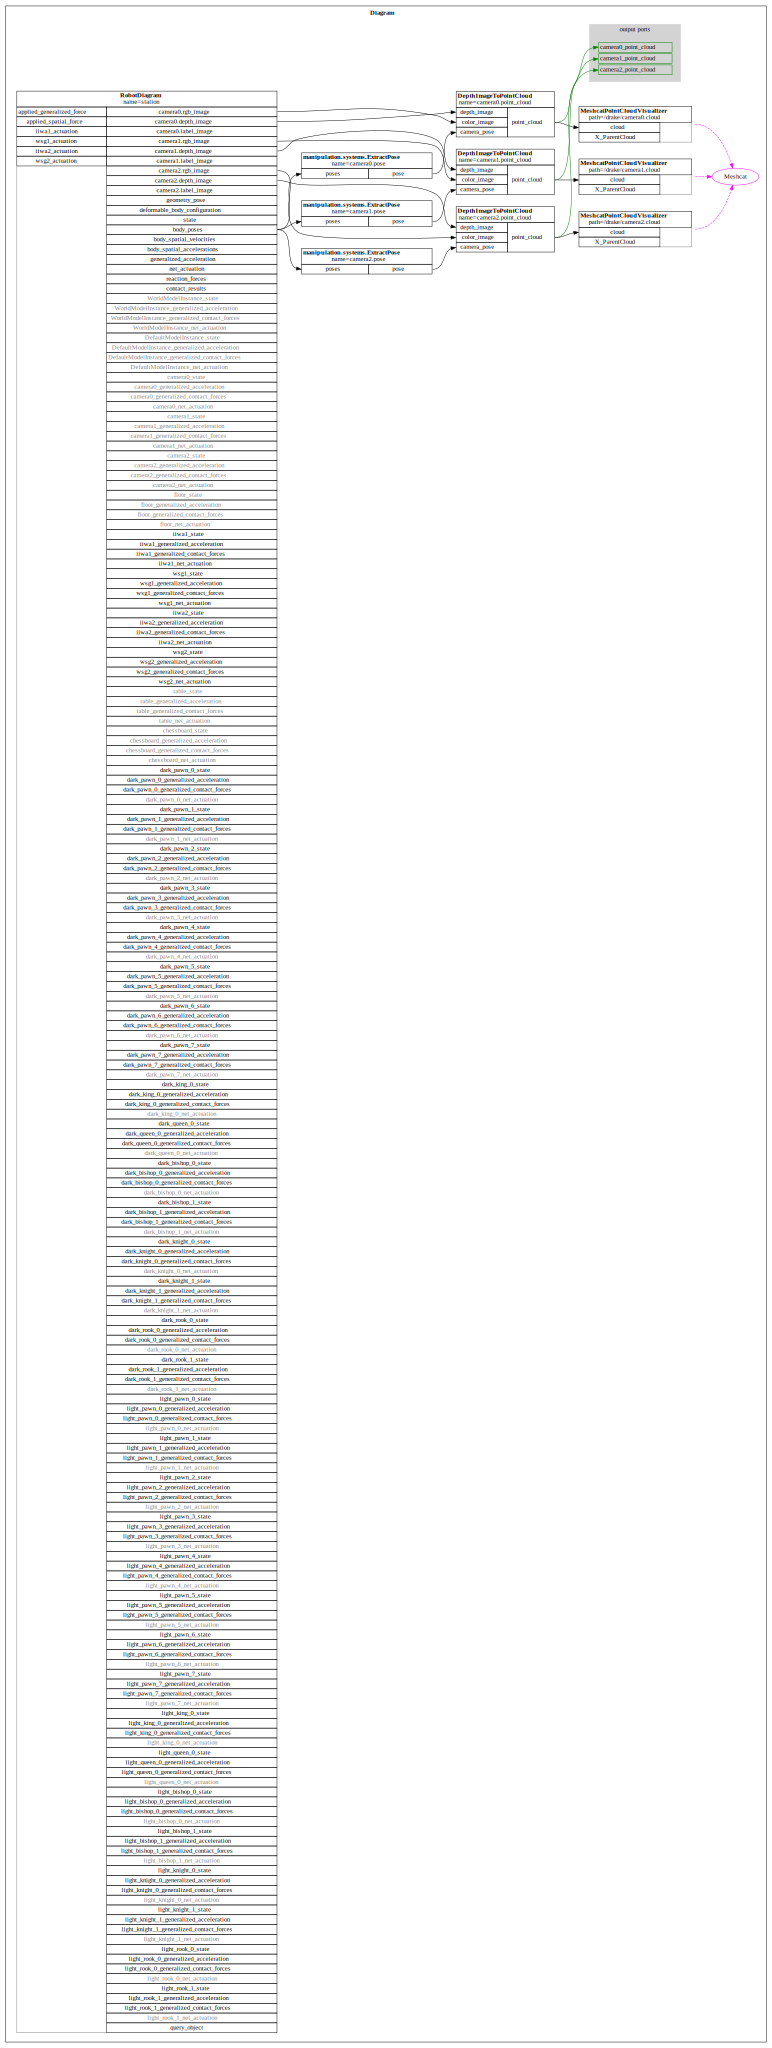

In [11]:
RenderDiagram(diagram, max_depth=1)

In [13]:
context = diagram.CreateDefaultContext()

In [12]:
# Create and run a simulator
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(0.1)

## Perception

### Sanity Checks

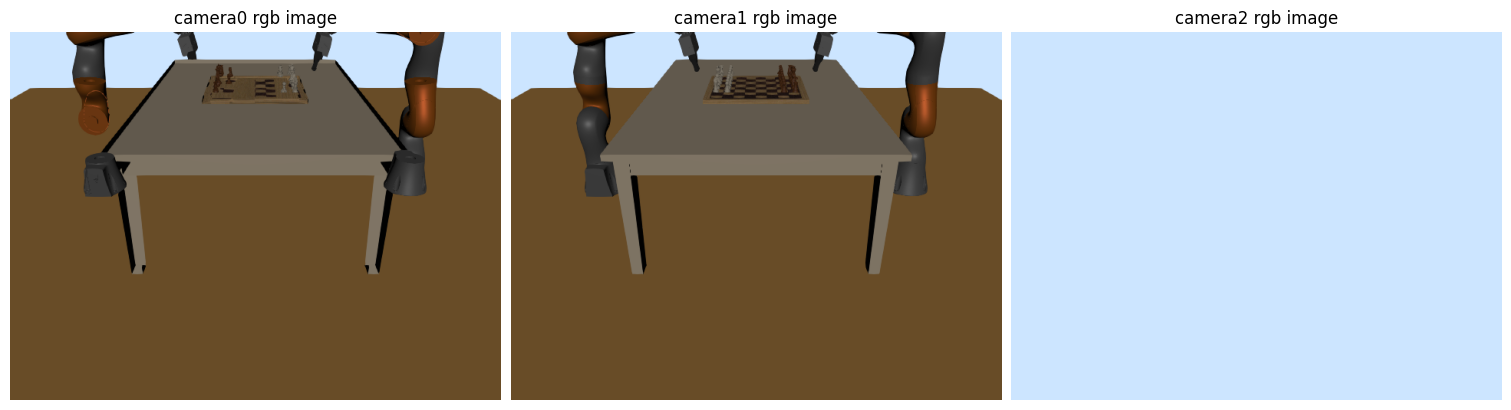

In [16]:
# Run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1", "camera2"]
station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

plt.show()

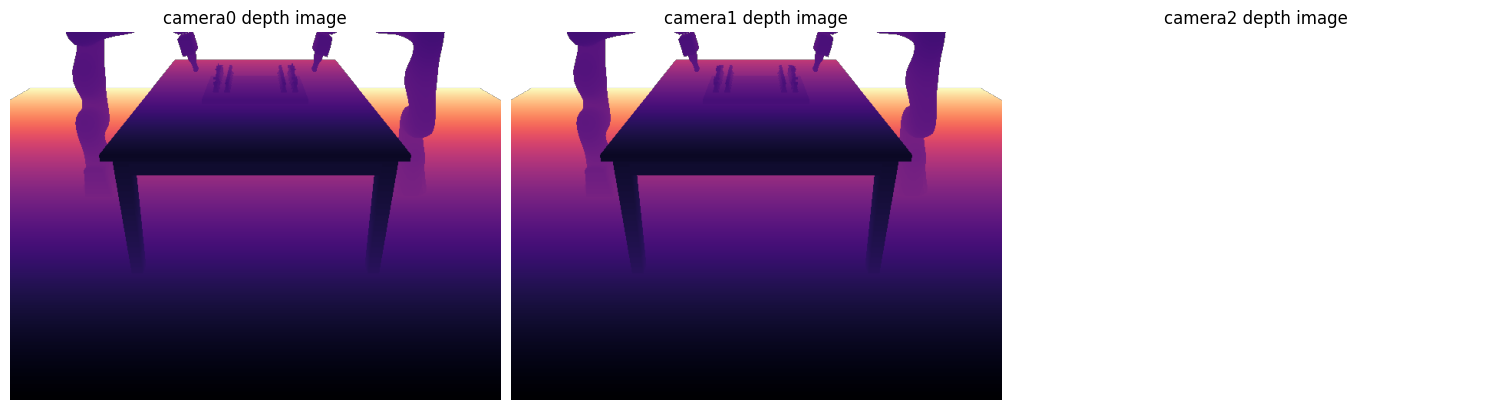

In [17]:
# Run the following cell to visualize the depth outputs of each of the cameras
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.depth_image").Eval(station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

plt.show()